# An RNN for short-term predictions
Think demand forecast based on past two weeks of sales data.

In [1]:
import numpy as np
from utils import datagen
from utils import display
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensorflow version: 1.4.1


## Generate fake dataset

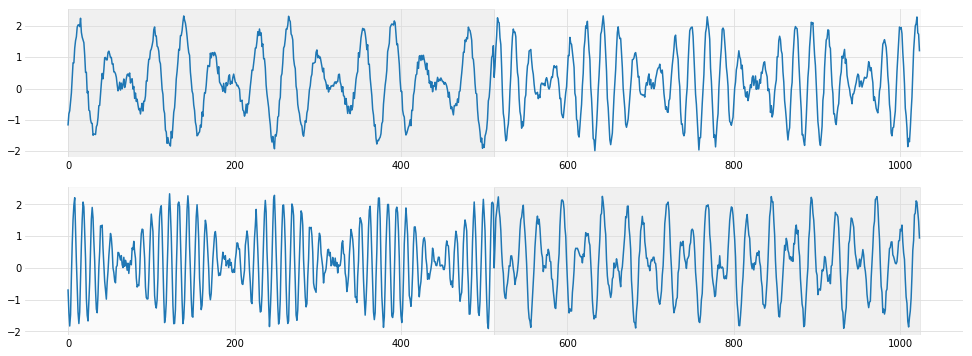

In [2]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([datagen.create_time_series(waveform, DATA_SEQ_LEN) for waveform in datagen.Waveforms])
display.picture_this_1(data, DATA_SEQ_LEN)

## Hyperparameters

In [3]:
RNN_CELLSIZE = 32    # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

## Visualize training sequences
This is what the neural network will see during training.

Tensor shape of a batch of training sequences: (32, 16)
Random excerpt:


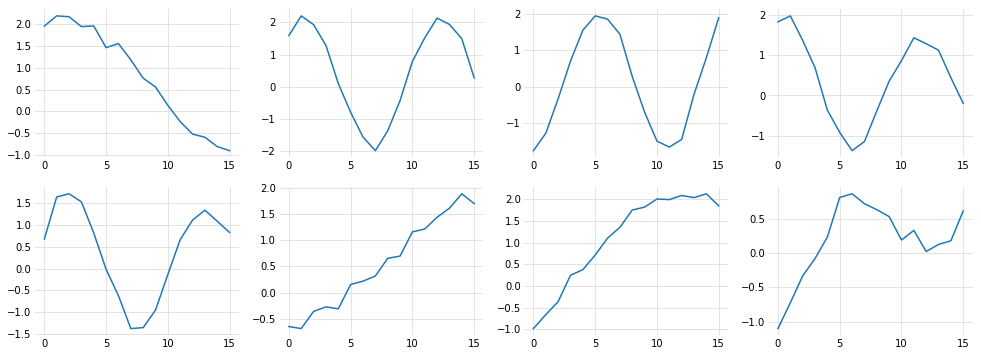

In [4]:
display.picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [5]:
# tree simplistic predictive models: can you beat them ?
def simplistic_models(X):
    # "random" model
    Yrnd = tf.random_uniform([tf.shape(X)[0]], -2.0, 2.0) # tf.shape(X)[0] is the batch size
    # "same as last" model
    Ysal = X[:,-1]
    # "trend from last two" model
    Ytfl = X[:,-1] + (X[:,-1] - X[:,-2])
    return Yrnd, Ysal, Ytfl

In [6]:
def bad_model(X):
    Yr = X * tf.Variable(tf.ones([]), name="dummy") # shape [BATCHSIZE, SEQLEN]
    Yout = Yr[:,-1:SEQLEN] # Last item in sequence. Yout [BATCHSIZE, 1]
    return Yout

In [7]:
# linear model (RMSE: 0.36, with shuffling: 0.17)
def linear_model(X):
    Yout = tf.layers.dense(X, 1) # output shape [BATCHSIZE, 1]
    return Yout

In [8]:
# 2-layer dense model (RMSE: 0.38, with shuffling: 0.15-0.18)
def DNN_model(X):
    Y = tf.layers.dense(X, SEQLEN//2, activation=tf.nn.relu)
    Yout = tf.layers.dense(Y, 1, activation=None) # output shape [BATCHSIZE, 1]
    return Yout

In [9]:
# convolutional (RMSE: 0.31, with shuffling: 0.16)
def CNN_model(X):
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    Y = tf.layers.conv1d(X, filters=8, kernel_size=4, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=16, kernel_size=3, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=1, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=3, activation=tf.nn.relu, padding="same")  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    Yout = tf.layers.conv1d(Y, filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid") # output shape [BATCHSIZE, 1, 1]
    Yout = tf.squeeze(Yout, axis=-1) # output shape [BATCHSIZE, 1]
    return Yout

In [10]:
# RNN model (RMSE: 0.38, with shuffling 0.14, the same with loss on last 8)
def RNN_model(X, n=1):
    # 2-layer RNN
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    cell1 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell2 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2], state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # Yn [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    
    # regression head
    batchsize = tf.shape(X)[0]
    Yn = tf.reshape(Yn, [batchsize*SEQLEN, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, SEQLEN, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    
    # In this RNN model, you can compute the loss on the last predicted item or the lats n predicted items
    # Last n is slightly better.
    Yout = Yr[:,-n:SEQLEN,:] # last item(s) in sequence: output shape [BATCHSIZE, n, 1]
    Yout = tf.squeeze(Yout, axis=-1)
    return Yout

In [11]:
def RNN_model_N(X): return RNN_model(X, n=SEQLEN//2)

In [12]:
def model_fn(features, labels, model=bad_model):
    X = features # shape [BATCHSIZE, SEQLEN]
    
    Y = model(X)

    last_label = labels[:, -1] # last item in sequence: the target value to predict
    last_labels = labels[:, -tf.shape(Y)[1]:SEQLEN] # last p items in sequence (as many as in Y), useful for RNN_model(X, n>1)

    loss = tf.losses.mean_squared_error(Y, last_labels) # loss computed on last label(s)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    Yrnd, Ysal, Ytfl = simplistic_models(X)
    eval_metrics = {"RMSE": tf.sqrt(loss),
                    # compare agains three simplistic predictive models: can you beat them ?
                    "RMSErnd": tf.sqrt(tf.losses.mean_squared_error(Yrnd, last_label)),
                    "RMSEsal": tf.sqrt(tf.losses.mean_squared_error(Ysal, last_label)),
                    "RMSEtfl": tf.sqrt(tf.losses.mean_squared_error(Ytfl, last_label))}
    
    Yout = Y[:,-1]
    return Yout, loss, eval_metrics, train_op

# prepare training dataset

In [13]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)
# slice data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# also make an evaluation dataset by randomly subsampling our fake data
EVAL_SEQUENCES = DATA_SEQ_LEN*4//SEQLEN//4
joined_data = np.stack([traindata, labeldata], axis=1) # new shape is [N_sequences, 2(train/eval), SEQLEN]
joined_evaldata = joined_data[np.random.choice(joined_data.shape[0], EVAL_SEQUENCES, replace=False)]
evaldata = joined_evaldata[:,0,:]
evallabels = joined_evaldata[:,1,:]

def datasets(nb_epochs):
    # Dataset API for batching, shuffling, repeating
    dataset = tf.data.Dataset.from_tensor_slices((traindata, labeldata))
    dataset = dataset.repeat(NB_EPOCHS)
    dataset = dataset.shuffle(DATA_SEQ_LEN*4//SEQLEN) # important ! Number of sequences in shuffle buffer: all of them
    dataset = dataset.batch(BATCHSIZE)
    
    # Dataset API for batching
    evaldataset = tf.data.Dataset.from_tensor_slices((evaldata, evallabels))
    evaldataset = evaldataset.repeat()
    evaldataset = evaldataset.batch(EVAL_SEQUENCES) # just one batch with everything

    # Some boilerplate code...
    
    # this creates a Tensorflow iterator of the correct type and shape
    # compatible with both our training and eval datasets
    tf_iter = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
    # it can be initialized to iterate through the training dataset
    dataset_init_op = tf_iter.make_initializer(dataset)
    # or it can be initialized to iterate through the eval dataset
    evaldataset_init_op = tf_iter.make_initializer(evaldataset)
    # Returns the tensorflow nodes needed by our model_fn.
    samples, labels = tf_iter.get_next()
    # When these nodes will be executed (sess.run) in the training or eval loop,
    # they will output the next batch of data.

    # Note: when you do not need to swap the dataset (like here between train/eval) just use
    # samples, labels = dataset.make_one_shot_iterator().get_next()
    # TODO: easier with tf.estimator.inputs.numpy_input_fn ???
    
    return samples, labels, dataset_init_op, evaldataset_init_op

## Instantiate the model

In [14]:
NB_EPOCHS = 10

# instantiate the dataset
samples, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
# instantiate the model
Yout, loss, eval_metrics, train_op = model_fn(samples, labels, CNN_model)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [15]:
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## The training loop
You can re-execute this cell to continue training

In [16]:
count = 0
losses = []
indices = []
sess.run(dataset_init_op)
while True:
    try: loss_, _ = sess.run([loss, train_op])
    except tf.errors.OutOfRangeError: break
    # print progress
    if count%300 == 0:
        epoch = count // (DATA_SEQ_LEN*4//BATCHSIZE//SEQLEN)
        print("epoch " + str(epoch) + ", batch " + str(count) + ", loss=" + str(loss_))
    if count%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(count)
    count += 1
    
# final evaluation
sess.run(evaldataset_init_op)
eval_metrics_, Yout_ = sess.run([eval_metrics, Yout])
print("Final accuracy on eval dataset:")
print(str(eval_metrics_))

epoch 0, batch 0, loss=0.878591
epoch 0, batch 300, loss=0.0906912
epoch 0, batch 600, loss=0.0281514
epoch 0, batch 900, loss=0.0652928
epoch 1, batch 1200, loss=0.0579623
epoch 1, batch 1500, loss=0.0431388
epoch 1, batch 1800, loss=0.0596462
epoch 2, batch 2100, loss=0.045663
epoch 2, batch 2400, loss=0.041114
epoch 2, batch 2700, loss=0.0380071
epoch 2, batch 3000, loss=0.0533356
epoch 3, batch 3300, loss=0.0252986
epoch 3, batch 3600, loss=0.0442534
epoch 3, batch 3900, loss=0.0338193
epoch 4, batch 4200, loss=0.0435465
epoch 4, batch 4500, loss=0.0500462
epoch 4, batch 4800, loss=0.0312027
epoch 4, batch 5100, loss=0.0422581
epoch 5, batch 5400, loss=0.0386234
epoch 5, batch 5700, loss=0.0355124
epoch 5, batch 6000, loss=0.0571451
epoch 6, batch 6300, loss=0.0417251
epoch 6, batch 6600, loss=0.0540126
epoch 6, batch 6900, loss=0.0314275
epoch 7, batch 7200, loss=0.0308034
epoch 7, batch 7500, loss=0.0252609
epoch 7, batch 7800, loss=0.0371683
epoch 7, batch 8100, loss=0.0686132
e

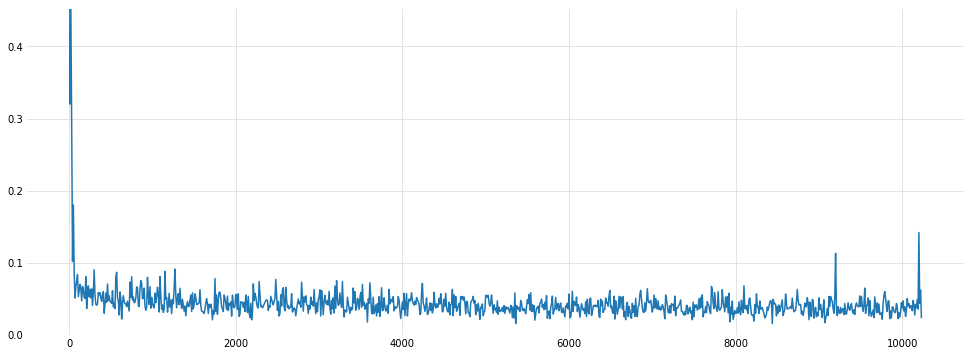

In [26]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value(s) for scaling
plt.plot(indices, losses)
plt.show()

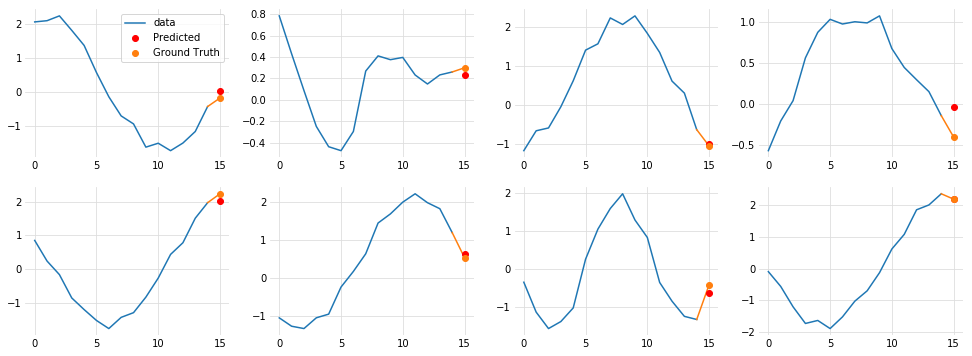

In [27]:
display.picture_this_3(Yout_, evaldata, evallabels, SEQLEN) # execute multiple times to see different sample sequences

In [ ]:
NB_EPOCHS = 10
sess.close()
models = [bad_model, linear_model, DNN_model, CNN_model, RNN_model, RNN_model_N]
for model in models:
    # reset tensorflow graph: start from scratch
    tf.reset_default_graph()
    # instantiate the dataset
    samples, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
    # instantiate model
    Yout, loss, eval_metrics, train_op = model_fn(samples, labels, model)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        # training loop
        sess.run([init, dataset_init_op])
        while True:
            try: sess.run(train_op)
            except tf.errors.OutOfRangeError: break
        # evaluation
        sess.run(evaldataset_init_op)
        eval_metrics_ = sess.run(eval_metrics)
        print(str(model))
        print(str(eval_metrics_))    

In [ ]:
# TODO: Estimator
# TODO: lab steps